# Google Earth Engine- Plotting Fire Data on a Bubble Map 

My name is Winifred, and I am a second-year student studying Computer Science at UC Berkeley. I was first exposed to data science one year ago and quickly realized just how applicable it is to various fields of study. After joining the Cabinet of Curiosity team, I learned more about existing natural history databases and collaborated with other team members to dive into and study these databases. I became particularly interested in the [Google Earth Engine database](https://earthengine.google.com/) and the vast amount of geophysical, climate, and imagery data it contained. Data visualization was also something I wanted to learn more about, which led me to exploring California wildfire data from the Earth Engine database and using Plotly to create a map that represented this data.. 

## Acquiring Data From Google Earth Engine

Google Earth Engine hosts satellite imagery and other geospatial data and is a tool that allows for analysis of these datasets, which are made available for global-scale data mining. Images of Earth may go back more than 40 years and are ingested on a daily basis. Datasets include the USGS/NASA Landsat catalog, precipitation data, elevation data, and many more. Earth Engine also allows users to upload their own data for analysis. 

Earth Engine has been used in many interesting case studies, such as the [Map of Life](http://species.mol.org/species/map/Perdix_dauurica), as well as analysis of [global forest cover change](http://species.mol.org/species/map/Perdix_dauurica).

## Downloading Data 

Browse the [Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/) to find a dataset that interests you. I picked one that contains [data about fires](https://developers.google.com/earth-engine/datasets/catalog/FIRMS). Notice the link  listed under the "Dataset Provider" section.

<img src = "../images/dataset_provider.PNG">


FIRMS provides "active fire data", which consists of data from the past 24 hours, 48 hours, and 7 days. However, because FIRMS data dates back to November 2000, I wanted to know how to download data older than 7 days.

Once you've reached the FIRMS dataset provider link, scroll down and select "Archive Download." Then, click on "Create New Request." 

<img src='../images/nasa_page.PNG'>

<img src='../images/archive_page.png'>

I wanted to narrow down the data to Southern California wildfires, so in the Download Request box, I decided to get data on a custom region and drew a polygon that roughly enclosed California. For fire data source, I chose VIIRS, which is an instrument  used to detect fires and gather data. My date range of choice was September 1st 2017 to September 1st 2018, and I decided to download it as a .csv file. Finally, you must enter your email so that FIRMS can send the data to you. You should receive an email within a few days.

<img src='../images/download_request.png'>

Once you receive the email, just download the .csv file, and you're ready to go! 

## Using Plotly for Python 

[Plotly](https://plot.ly/#/) has a [Python library](https://plot.ly/python/) that allows you to create interactive data visualizations online, such as line plots, scatter maps, heatmaps, and 3D network graphs. In this tutorial, we will create a bubble map that visualizes wildfire data in California (based on the FIRMS data we acquired). 

I knew I wanted to visualize the data using a map, and after looking at many different graphing libraries, I decided to use Plotly. Plotly seemed to be the most user-friendly because the website had very thorough [map tutorials](https://plot.ly/python/maps/) and easy-to-follow [documentation](https://plot.ly/python/reference/#scattergeo). Additionally, Plotly hosts graphs, which can be embedded anywhere. These graphs are saved in your account.  

First, install Plotly's Python package using

``` pip install plotly```

Next, [create an account](https://plot.ly/Auth/login/?action=signup&next=%2Fsettings%2Fapi#/) and obtain your API key. This will be used to set your credentials. 

Now, you're ready to fire up Python and set up your credentials: 

```import plotly 
plotly.tools.set_credentials_file(username='your_username', api_key='your_api_key') ```


Once that is done, let's import some libraries that we will use in this tutorial:

In [1]:
import plotly.plotly as py
import pandas as pd
from datascience import *
import numpy as np

#included for distribution figures.
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Our FIRMS dataset is quite big, so let's narrow it down to just a few points on the map. I'd like to plot the 5 brightest, 5 middle, and 5 dimmest wildfires in the dataset. 

First, let's load the .csv file into a table:

In [2]:
data= pd.read_csv('../data/SoCal_fires.csv')  #pandas
## data=Table().read_table('~../data/SoCal_fires.csv') 
data.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,type
0,36.234,-118.430,321.9,1.0,1.0,2017-10-07,1845,Terra,MODIS,44,6.1,302.5,14.5,0
1,36.258,-118.421,319.4,4.7,2.0,2017-10-15,1756,Terra,MODIS,72,6.1,294.9,138.7,0
2,36.259,-118.425,318.2,4.7,2.0,2017-10-15,1756,Terra,MODIS,44,6.1,294.4,118.3,0
3,36.256,-118.420,345.1,1.1,1.0,2017-10-15,2112,Aqua,MODIS,92,6.1,298.3,50.0,0
4,36.272,-118.429,326.3,1.1,1.0,2017-10-16,1839,Terra,MODIS,71,6.1,293.0,23.1,0


## Filtering the data

Now, let's select our columns of interest. For the purposes of this tutorial, we care about the latitude, longitude, brightness, and dates of our data.

In [3]:
# list(data) # list all the column names
py_data = data[['latitude', 'longitude', 'brightness', 'acq_date']] #pandas

#py_data=data.select(0,1,2,5) #get the columns you want
#py_data

Next, let's find the top 5 brightest fires in our data. To do this, we can sort the brightness from brightest to dimmest, and use the numpy.take method to grab the first 5 rows. You will also do the same thing to find the 5 dimmest fires, except you will sort from dimmest to brightest.

In [4]:
brightest=py_data.sort_values(by='brightness', ascending=True)#.take(range(0,5)) #pandas
# brightest=py_data.sort('brightness', descending=True).take(range(0,5))

In [5]:
dimmest=py_data.sort_values(by='brightness', ascending=False).take(range(0,5)) #pandas
# dimmest=py_data.sort('brightness',descending=False).take(range(0,5))

## Subsetting the data 

Now, let's subset and look at the distribution of the data. We probably wouldn't expect there to be an equal amount of fires throughout the varying degrees of brightness; if that were the case, we'd have just as many small, dim fires as large, intense fires. 


In [6]:
##I love the purpose of this section, to make smaller and be able to visualize, but this may not be the best way to do it based on the distribution of the data (next cell).
#As you can see, most of the data is skewed toward the 300 to 350. 
#I think a more appropriate way would be to make into quantiles

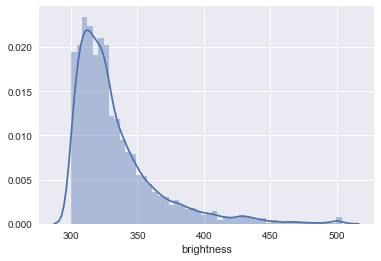

In [7]:
## Let's lool at the distribution of the brightness.
%matplotlib inline

sns.set(color_codes=True)
sns.distplot(py_data['brightness'])

In [8]:
py_data['quantile'] = pd.qcut(py_data['brightness'], 3, labels=["dim", "moderate", "bright"]) ## Split into three quanitles.
py_data.head()

C:\Users\winif\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,latitude,longitude,brightness,acq_date,quantile
0,36.234,-118.430,321.9,2017-10-07,moderate
1,36.258,-118.421,319.4,2017-10-15,moderate
2,36.259,-118.425,318.2,2017-10-15,moderate
3,36.256,-118.420,345.1,2017-10-15,bright
4,36.272,-118.429,326.3,2017-10-16,moderate


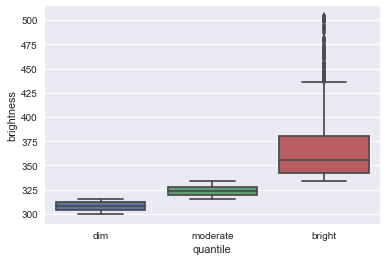

In [9]:
sns.boxplot(data=py_data, x='quantile', y='brightness')
#sns.distplot(py_data['brightness'], hue='quantile')

In [10]:
#new stuff!
#randomly pick from each quantile 
#np.random.choice on array where quantile = bright/moderate/dim
#filter out the tables 
dim_data = py_data[py_data["quantile"] == "dim"]
moderate_data = py_data[py_data["quantile"] == "moderate"]
bright_data = py_data[py_data["quantile"] == "bright"]

In [11]:
dim_sample = dim_data.sample(n=5)
dim_sample

,latitude,longitude,brightness,acq_date,quantile
3467,36.978,-120.195,312.6,2017-12-04,dim
86,35.933,-119.267,315.2,2017-11-15,dim
4547,34.442,-118.929,311.7,2017-12-12,dim
5935,34.516,-119.446,313.4,2017-12-12,dim
5807,34.831,-118.410,311.4,2018-01-04,dim


In [12]:
moderate_sample = moderate_data.sample(n=5)
moderate_sample

,latitude,longitude,brightness,acq_date,quantile
5771,34.243,-118.329,331.4,2017-09-02,moderate
1614,36.274,-118.464,320.3,2017-10-08,moderate
4297,34.508,-119.169,320.0,2017-12-07,moderate
3846,36.623,-121.748,322.0,2017-10-05,moderate
4582,34.484,-118.987,325.0,2017-12-16,moderate


In [13]:
bright_sample = bright_data.sample(n=5)
bright_sample

,latitude,longitude,brightness,acq_date,quantile
1415,37.962,-120.033,361.6,2017-11-07,bright
4382,34.401,-119.061,402.0,2017-12-05,bright
4357,34.554,-119.139,368.9,2017-12-17,bright
1216,34.628,-119.422,481.8,2017-12-18,bright
997,34.420,-119.196,363.5,2017-12-05,bright


Now that we have sampled from each quantile, let's create a new table with all of the sampled data. 

In [14]:
#append the dataframes to each other and sort by increasing brightness
sorted_samples = dim_sample.append(moderate_sample).append(bright_sample).sort_values("brightness")
sorted_samples

,latitude,longitude,brightness,acq_date,quantile
5807,34.831,-118.410,311.4,2018-01-04,dim
4547,34.442,-118.929,311.7,2017-12-12,dim
3467,36.978,-120.195,312.6,2017-12-04,dim
5935,34.516,-119.446,313.4,2017-12-12,dim
86,35.933,-119.267,315.2,2017-11-15,dim
4297,34.508,-119.169,320.0,2017-12-07,moderate
1614,36.274,-118.464,320.3,2017-10-08,moderate
3846,36.623,-121.748,322.0,2017-10-05,moderate
4582,34.484,-118.987,325.0,2017-12-16,moderate
5771,34.243,-118.329,331.4,2017-09-02,moderate


In [15]:
#fix the indices 
sorted_samples.index = range(15)
sorted_samples

,latitude,longitude,brightness,acq_date,quantile
0,34.831,-118.410,311.4,2018-01-04,dim
1,34.442,-118.929,311.7,2017-12-12,dim
2,36.978,-120.195,312.6,2017-12-04,dim
3,34.516,-119.446,313.4,2017-12-12,dim
4,35.933,-119.267,315.2,2017-11-15,dim
5,34.508,-119.169,320.0,2017-12-07,moderate
6,36.274,-118.464,320.3,2017-10-08,moderate
7,36.623,-121.748,322.0,2017-10-05,moderate
8,34.484,-118.987,325.0,2017-12-16,moderate
9,34.243,-118.329,331.4,2017-09-02,moderate


Finding the middle 5 fires will take a bit more work. First, we will find the median of our brightness values. Then, we will find the index of table in which the median is located. Finally, we will want to take the two rows above the median and the two rows below the median to get the middle 5 of the table. 

In [16]:
## Essentially you are just looking to find medium row and idetify idex number
## something is wrong here. 

##py_data[['brightness']].median() # pandas
##py_data[py_data.brightness==py_data.median()['brightness']] # pandas
##py_data[py_data.brightness == 323.8] #pandas

## You see how the median brightness is 323.8, but that applies to 14 rows?  
## So what you did should just be five observations with 323.5.


## Old
## bright_col=py_data.sort('brightness',descending=False).column('brightness') #the brightness column of our data
## medium=np.median(bright_col) #find median of brightnesses
## list(bright_col).index(medium) #find index of median

In [17]:
#middle=py_data.take(range((3017-2),(3017+3))) #take two above and two below median to get "middle 5 brightest"
#middle

Now, it's time to concatenate all our data! I am going to create arrays for each variable that we are interested in, using data from our "brightest", "middle", and "dimmest" tables.

In [18]:
#lats=np.append(np.append(brightest.column(0),(middle.column(0))), dimmest.column(0)) #latitudes  
#longs=np.append(np.append(brightest.column(1),(middle.column(1))), dimmest.column(1)) #longitudes
#brights=np.append(np.append(brightest.column(2),(middle.column(2))), dimmest.column(2)) #brightnesses
#dates=np.append(np.append(brightest.column(3),(middle.column(3))), dimmest.column(3)) #dates

Now, let's create a new table with columns for these variables! This table will contain the latitude, longitude, brightness, and dates of the top 5 brightest, middle 5, and 5 dimmest fire data. 

In [19]:
#d = {'latitude': lats,
 #       'longitude': longs,
#      'brightness': brights,
 #       'acq_date': dates}
#pandas_filtered = pd.DataFrame(data = d)
#pandas_filtered.head()

## Plotting the data

Here's where things get a bit tricky. Ultimately, we would like to plot a figure with a specific set of data and a specific layout. Plotly has many attributes to help us accomplish our goal, but how do we know which ones to use? Luckily, Plotly has a [figure reference!](https://plot.ly/python/reference/)

Let's initialize our data first. We want to have different-colored bubbles on our bubble map so that we can differentiate between the three levels of brightness. Let's create a list of colors to choose from, using their RGB values: 

In [20]:
colors = ["rgb(255,255,0)", "rgb(255,128,0)", "rgb(255,0,0)"] #red, orange, yellow

Next, we'll create a list called limits. Limits contains three elements, and each element contains the beginning index and ending index of a brightness level. This list will allow us to map certain attributes to a specific range of data. For example, if we assign the first element of [colors] to the first element in [limits], the 5 brightest fires will appear as red bubbles on the map.

In [21]:
limits=[(0,5),(5,10),(10,15)] #we are grouping by brightness, where first five (0,5) are brightest, second group of five (5,10) are moderately bright, etc.

Now, it's time to create a list that contains all the information that we want to represent on the map. We'll call this list "fires." In the end, we want this list to hold three dictionaries (one for each brightness level). 

Since we have three brightness levels, we want to assign specific attributes to each of them. To do this, we will iterature through each of the groups and create a dictionary of attributes for each. If you are unclear about these attributes, refer to the [figure reference!](https://plot.ly/python/reference/).

In [22]:
sorted_dim= sorted_samples.loc[np.r_[0:5]]
#sorted_dim["brightness"].at[0]
sorted_dim

,latitude,longitude,brightness,acq_date,quantile
0,34.831,-118.410,311.4,2018-01-04,dim
1,34.442,-118.929,311.7,2017-12-12,dim
2,36.978,-120.195,312.6,2017-12-04,dim
3,34.516,-119.446,313.4,2017-12-12,dim
4,35.933,-119.267,315.2,2017-11-15,dim


In [23]:
sorted_moderate=sorted_samples.loc[np.r_[5:10]]
sorted_moderate

,latitude,longitude,brightness,acq_date,quantile
5,34.508,-119.169,320.0,2017-12-07,moderate
6,36.274,-118.464,320.3,2017-10-08,moderate
7,36.623,-121.748,322.0,2017-10-05,moderate
8,34.484,-118.987,325.0,2017-12-16,moderate
9,34.243,-118.329,331.4,2017-09-02,moderate


In [24]:
sorted_bright=sorted_samples.loc[np.r_[10:15]]
sorted_bright


,latitude,longitude,brightness,acq_date,quantile
10,37.962,-120.033,361.6,2017-11-07,bright
11,34.420,-119.196,363.5,2017-12-05,bright
12,34.554,-119.139,368.9,2017-12-17,bright
13,34.401,-119.061,402.0,2017-12-05,bright
14,34.628,-119.422,481.8,2017-12-18,bright


In [25]:
fires=[] #the data that we want to represent on the map
    
for i in range(len(limits)): #we want to iterate 3 times to create 3 traces on the map 
    #for the purpose of scaling the size of each bubble, we will divide by a factor and also scale this factor so we get a bigger
    #variation in size 
    if i == 0: 
        scale = 17*1.2
    elif i == 2: 
        scale = 17*0.8
    else: 
        scale = 17
    group = sorted_samples.loc[np.r_[limits[i][0]:limits[i][1]]]
    fire=dict(
        type = 'scattergeo', #the type of figure we want to create 
        locationmode = 'USA-states', 
        lon = group['longitude'],
        lat = group['latitude'],
        marker=dict(
                #scale the size of the bubble; our bubble size is based on the brightness 
                size = group["brightness"].at[limits[i][0]]/scale, #difference in size is too subtle if we just use one number for scale
                color=colors[i], #the color of the bubbles in this group 
                line = dict(width=0.5, color='rgb(40,40,40)'), 
                sizemode='diameter'
                ), #sets the properties of the bubbles 
        name='{0}-{1}'.format(limits[i][0], limits[i][1])) #legend labels
    fires.append(fire)

Let's see what our "fires" dictionary looks like: 

In [26]:
fires

[{'lat': 0    34.831
  1    34.442
  2    36.978
  3    34.516
  4    35.933
  Name: latitude, dtype: float64,
  'locationmode': 'USA-states',
  'lon': 0   -118.410
  1   -118.929
  2   -120.195
  3   -119.446
  4   -119.267
  Name: longitude, dtype: float64,
  'marker': {'color': 'rgb(255,255,0)',
   'line': {'color': 'rgb(40,40,40)', 'width': 0.5},
   'size': 15.264705882352942,
   'sizemode': 'diameter'},
  'name': '0-5',
  'type': 'scattergeo'},
 {'lat': 5    34.508
  6    36.274
  7    36.623
  8    34.484
  9    34.243
  Name: latitude, dtype: float64,
  'locationmode': 'USA-states',
  'lon': 5   -119.169
  6   -118.464
  7   -121.748
  8   -118.987
  9   -118.329
  Name: longitude, dtype: float64,
  'marker': {'color': 'rgb(255,128,0)',
   'line': {'color': 'rgb(40,40,40)', 'width': 0.5},
   'size': 18.823529411764707,
   'sizemode': 'diameter'},
  'name': '5-10',
  'type': 'scattergeo'},
 {'lat': 10    37.962
  11    34.420
  12    34.554
  13    34.401
  14    34.628
  Name: l

Next, we will dictate what our figure layout should be. 

In [27]:
layout=dict(
        title='Range of Wildfire Brightnesses in California from 09/01/2017 to 09/01/2018',
        showlegend=True,
        geo = dict(
            projection=dict( type='albers usa'), #provides the gray USA map 
            center=dict(lon=-116.4194, lat=34.9592), #centers the map on the middle of SoCal when you first create the map
            zoom=6, #Zoom factor of map when you create it 
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires, layout=layout) #our figure with fires data and the layout we want 
py.iplot(fig, validate=False, filename='SoCal-FIRMS-bubble-map') #plot the data! 

<img src = "../images/firstplot.PNG">

## Add more data points! 
Here, I am just doing the same steps but getting a total of 300 data points in the end and tweaking the map.

In [35]:
brightest100=bright_data.sample(n=100).sort_values('brightness')
brightest100

,latitude,longitude,brightness,acq_date,quantile
1339,35.852,-119.218,334.6,2017-11-11,bright
3958,36.069,-118.769,334.7,2017-09-16,bright
3380,36.622,-119.562,335.6,2017-09-09,bright
590,37.676,-119.571,336.4,2017-10-17,bright
3513,37.689,-120.753,336.9,2017-09-12,bright
2361,34.511,-119.554,337.5,2017-12-16,bright
3713,36.703,-119.485,337.8,2017-09-29,bright
1833,34.453,-119.348,337.8,2017-12-09,bright
969,34.355,-119.187,338.0,2017-12-05,bright
2979,34.330,-119.299,338.1,2017-12-06,bright


In [65]:
dimmest100=dim_data.sample(n=100).sort_values('brightness')

#py_data.sort('brightness', descending=False).take(range(0, 100))
dimmest100

,latitude,longitude,brightness,acq_date,quantile
6,36.255,-118.412,300.0,2017-10-16,dim
3747,37.469,-120.705,300.1,2017-11-18,dim
4615,36.659,-119.839,300.1,2017-12-04,dim
5312,34.512,-119.160,300.2,2017-12-08,dim
6004,37.234,-120.307,301.1,2017-11-28,dim
2206,37.215,-119.429,301.4,2017-11-30,dim
416,35.858,-119.193,301.5,2018-01-26,dim
2172,34.468,-119.049,301.5,2017-12-09,dim
3311,37.381,-120.767,301.6,2018-01-28,dim
3661,37.916,-120.959,301.6,2017-12-17,dim


In [37]:
moderate100= moderate_data.sample(n=100).sort_values('brightness')
moderate100

,latitude,longitude,brightness,acq_date,quantile
950,35.913,-119.132,315.9,2017-11-11,moderate
1813,34.510,-119.362,315.9,2017-12-08,moderate
3073,34.434,-119.426,316.0,2017-12-16,moderate
5396,36.331,-118.531,316.1,2017-10-04,moderate
1702,34.524,-119.467,316.1,2017-12-10,moderate
1290,36.848,-120.059,316.2,2018-05-11,moderate
1803,34.516,-119.362,316.5,2017-12-08,moderate
298,37.435,-119.636,316.6,2017-09-06,moderate
5742,36.320,-119.118,316.7,2017-09-15,moderate
2375,34.431,-119.183,316.9,2017-12-06,moderate


In [83]:
sorted_300=dimmest100.append(moderate100).append(brightest100)
sorted_300.index = range(300)
sorted_300["label"] = sorted_300['brightness'].astype(str) + ', ' + sorted_300['acq_date'].astype(str)
sorted_300.head()

,latitude,longitude,brightness,acq_date,quantile,label
0,36.255,-118.412,300.0,2017-10-16,dim,"300.0, 2017-10-16"
1,37.469,-120.705,300.1,2017-11-18,dim,"300.1, 2017-11-18"
2,36.659,-119.839,300.1,2017-12-04,dim,"300.1, 2017-12-04"
3,34.512,-119.160,300.2,2017-12-08,dim,"300.2, 2017-12-08"
4,37.234,-120.307,301.1,2017-11-28,dim,"301.1, 2017-11-28"


One thing I wanted to do was add the brightness value and date to the label of each bubble. 

First, I created a function called "labels" that takes in two columns and combines their values into a single array. For example, I took the "brightness" column and "acq_date" column from our table and returned an array with "< brightness value >, < date >" for each fire. 

In [86]:
#example of a single label 
sorted_300["label"].iloc[0]

'300.0, 2017-10-16'

Then, I added a "text" attribute to the fire dictionary and set it equal to a specific splice of the "labels300" array. I also changed the trace names in the legend by creating a new list of labels called "legend labels" and editing the "name" attribute in the fire dictionary.

In [23]:
limits300=[(0,100),(100,200),(200,300)]
legendlabels=['Bright','Moderate', 'Dim'] #new legend labels 
fires300=[] 
for i in range(len(limits)): 
    group=filtered_data300.take(range(limits300[i][0], limits300[i][1])) 
    fire=dict(
        type = 'scattergeo',
        locationmode = 'USA-states', 
        lon = group['longitude'],
        lat = group['latitude'],
        text= labels300[range(limits300[i][0], limits300[i][1])],
        location=['California'], 
        marker=dict(
                size=group['brightness']/20, 
                color=colors[i], 
                line = dict(width=0.5, color='rgb(40,40,40)'), 
                sizemode='diameter'
                ), 
        name=legendlabels[i]) 
    fires300.append(fire)


In [24]:
layout300=dict(
        title='Range of Wildfire Brightnesses in California from 09/01/2017 to 09/01/2018',
        showlegend=True,
        opacity=0.7, #made the bubbles see-through 
        geo = dict(
            projection=dict( type='albers usa'), 
            center=dict(lon=-119.4179, lat=36.7783), 
            showland = True,
            landcolor = 'rgb(64,64,64)', #changed color of map to dark gray 
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires300, layout=layout300)
py.iplot(fig, validate=False, filename='FIRMS300-bubble-map') 

<img src = "../images/secondplot.PNG">

Tip: you can hide a specific trace by clicking on its bubble in the legend! 

As we can see, the most intense fires of 2017 seem to be located in the area north of Los Angeles. The bubble labels indicate that these fires spanned the first two weeks of December 2017. On the other hand, fires with less intensity were scattered up and down the Central Valley. 

## Using the CA Oct 2017- Apr 2018 dataset

The `ca1718.csv` file contians FIRMS data for Calfornia's 2017-2018 fire season, which lasts from October to April. I performed the same actions as above, taking a total of 300 data points for the visualization.

In [51]:
data1718=pd.read_csv('../data/ca1718.csv')[['latitude', 'longitude', 'bright_ti4', 'acq_date']]
#Table().read_table('~/URAP/google_earth_fires/data/ca1718.csv').sort('bright_ti4', descending=True).select(0,1,2,5)
data1718

,latitude,longitude,bright_ti4,acq_date
0,40.73124,-124.00435,295.3,2017-11-30
1,40.64605,-123.88713,336.2,2018-04-25
2,39.94927,-120.95713,326.1,2017-11-06
3,39.65937,-121.01781,327.8,2017-11-28
4,39.69487,-121.00845,331.8,2017-11-28
5,39.69951,-120.99900,316.3,2017-11-29
6,39.67944,-120.99520,305.9,2017-11-29
7,39.67498,-121.00217,302.1,2017-11-29
8,39.69501,-120.99912,299.2,2017-11-29
9,39.67144,-120.98780,301.4,2017-11-29


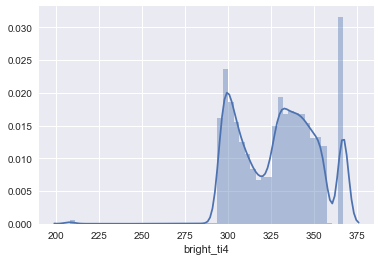

In [52]:
## Let's lool at the distribution of the brightness.
%matplotlib inline

sns.set(color_codes=True)
sns.distplot(data1718['bright_ti4'])

In [57]:
data1718['quantile'] = pd.qcut(data1718['bright_ti4'], 3, labels=["dim", "moderate", "bright"])
data1718

,latitude,longitude,bright_ti4,acq_date,quantile
0,40.73124,-124.00435,295.3,2017-11-30,dim
1,40.64605,-123.88713,336.2,2018-04-25,moderate
2,39.94927,-120.95713,326.1,2017-11-06,moderate
3,39.65937,-121.01781,327.8,2017-11-28,moderate
4,39.69487,-121.00845,331.8,2017-11-28,moderate
5,39.69951,-120.99900,316.3,2017-11-29,moderate
6,39.67944,-120.99520,305.9,2017-11-29,dim
7,39.67498,-121.00217,302.1,2017-11-29,dim
8,39.69501,-120.99912,299.2,2017-11-29,dim
9,39.67144,-120.98780,301.4,2017-11-29,dim


In [61]:
dim1718 = data1718[data1718['quantile'] == 'dim'].sample(100).sort_values('bright_ti4')
moderate1718 = data1718[data1718['quantile'] == 'moderate'].sample(100).sort_values('bright_ti4')
bright1718 = data1718[data1718['quantile'] == 'bright'].sample(100).sort_values('bright_ti4')

In [88]:
sorted_1718 = dim1718.append(moderate1718).append(bright1718)
sorted_1718.index = range(300)
sorted_1718

,latitude,longitude,bright_ti4,acq_date,quantile
0,35.91271,-119.13972,270.9,2017-11-15,dim
1,34.39699,-119.00618,295.0,2017-12-07,dim
2,37.63120,-119.56678,295.2,2017-10-16,dim
3,34.57362,-119.37040,295.3,2017-12-15,dim
4,37.96650,-122.38176,295.5,2017-10-20,dim
5,37.45330,-121.93023,295.6,2018-03-26,dim
6,34.62332,-117.09986,295.6,2017-12-26,dim
7,36.23407,-118.47754,295.7,2017-10-13,dim
8,37.18806,-119.39281,295.8,2018-02-24,dim
9,38.38103,-122.42643,296.0,2017-10-13,dim


In [90]:
labels1718=labels(filtered1718.column('brightness'),filtered1718.column('acq_date'))

In [95]:
limits1718=[(0,100),(100,200),(200,300)]
legendlabels=['Bright','Moderate', 'Dim']
fires1718=[] 
for i in range(len(limits1718)): 
    group=filtered1718.take(range(limits1718[i][0], limits1718[i][1])) #i.e: in the first iteration, we are taking the top 100 rows (the brightest) 
    fire=dict(
        type = 'scattergeo',
        locationmode = 'USA-states', 
        lon = group['longitude'],
        lat = group['latitude'],
        text= labels1718[range(limits1718[i][0], limits1718[i][1])], 
        marker=dict(
                size=group['brightness']/20, 
                color=colors[i], 
                line = dict(width=0.5, color='rgb(40,40,40)'), #the outline of each bubble 
                sizemode='diameter'
                ), 
        name=legendlabels[i]) 
    fires1718.append(fire)

In [96]:
layout1718=dict(
        title='Range of Wildfire Brightnesses in California from 10/01/2017 to 04/30/2018',
        showlegend=True,
        opacity=0.7,
        geo = dict(
            projection=dict( type='albers usa'), 
            center=dict(lon=-119.4179, lat=36.7783), 
            showland = True,
            landcolor = 'rgb(64,64,64)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
fig = dict(data=fires1718, layout=layout1718)
py.iplot(fig, validate=False, filename='FIRMS1718-bubble-map') 

<img src = "../images/thirdplot.PNG">

# Conclusion 
It was quite an experience learning how to translate data that I found on Google Earth Engine into a visual representation using Plotly. Plotly was quite difficult to figure out at first, but I was able to make a few tweaks that improved the graph a bit. It was interesting to see how a majority of wildfires occurred around Central California. Additionally, the majority of the worst fires during the 2017-18 wildfire season occurred in Northern California. 

There are still a few things I'd like to tweak in this project. I spent a while trying to figure out how to get a gradient scale in the legend to see just how much brightness varies among these fires, but was unable to find a way. There are also multiple data points that represent the same fires, except the data were recorded on different days. It would be helpful to clean the data a bit more to ensure there are no repetitive points. This would also clean up the visual aspect of the map. 

Overall, I was glad to have learned more about data visualization and the Plotly Python Library. Familiarizing myself with all the methods will definitely be helpful for future data exploration. I was also surprised by the amount of fire data there are on the internet, and I'm glad that Google Earth Engine provides an easy way to discover such datasets. 